In [ ]:
#filename = 'gpt-3.5-turbo-text-embedding-ada-002'
#filename = 'gemma2-9b-it-text-embedding-ada-002'
filename = 'gpt-4o-text-embedding-ada-002'
#filename = 'gpt-4o-text-embedding-3-large'
experiment = '-p1'
GROLTS_LABELS = False

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

pd.set_option('future.no_silent_downcasting', True)

path = './data_out/'

# Single Eval

Summed Acc:  11.81578947368421


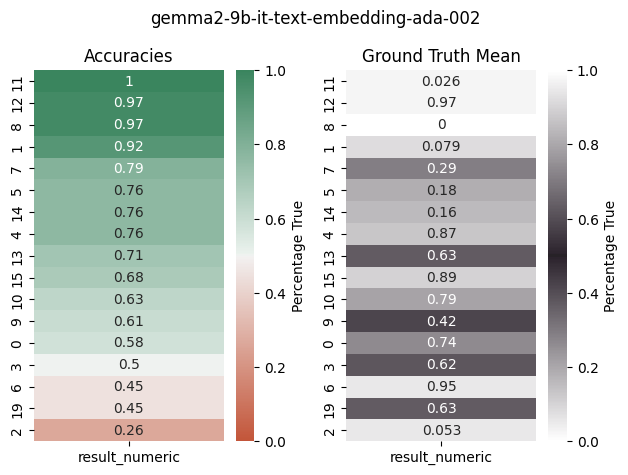

In [90]:
df = pd.read_csv(path + filename + experiment + '.csv')
df.replace(('YES', 'NO'), (1, 0), inplace=True)
df_labels = pd.read_csv('./data_out/human_labels.csv', delimiter=';')

res = {}
for i in range(38):
    pred = df[df['Paper'] == i]
    true = df_labels[df_labels['paper_id'] == i]
    
    paper_res = {}
    for col in pred:
        if col != 'Paper':
            paper_res[col] = pred[col].values[0] == true[col].values[0]
    res[i] = paper_res

df_res = pd.DataFrame.from_dict(res, orient='index')

fig, (ax1, ax2) = plt.subplots(1, 2)

df_res = df_res.reset_index().rename(columns={"index":"paper_id"})	
df_test = df_res.melt(id_vars=['paper_id'], value_vars=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '19'], var_name='question', value_name='result')

df_test['result_numeric'] = df_test['result'].astype(int)

percent_true_by_question = df_test.groupby('question')['result_numeric'].mean().reset_index()
percent_true_by_question = percent_true_by_question.sort_values(by='result_numeric', ascending=False)
print('Summed Acc: ', percent_true_by_question.sum()['result_numeric'])
g = sns.heatmap(
    percent_true_by_question.set_index('question'),
    annot=True, 
    cmap=sns.diverging_palette(20, 145, as_cmap=True), 
    cbar_kws={'label': 'Percentage True'},
    vmin=0, vmax=1, ax=ax1
)
g.set_title('Accuracies')
g.set_xlabel('')
g.set_ylabel('')
if GROLTS_LABELS:
    g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '15'])  # Sort y-ticks numerically

df_lab = df_labels.melt(id_vars=['paper_id'], value_vars=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '19'], var_name='question', value_name='result')

df_lab['result_numeric'] = df_lab['result']

percent_true_by_question_lab = df_lab.groupby('question')['result_numeric'].mean().reset_index()
percent_true_by_question_lab = percent_true_by_question_lab.reindex(percent_true_by_question.index)

g = sns.heatmap(
    percent_true_by_question_lab.set_index('question'),
    annot=True,
    cmap=sns.diverging_palette(0, 0, l=100, center="dark", as_cmap=True),
    cbar_kws={'label': 'Percentage True'},
    vmin=0, vmax=1, ax=ax2
)
g.set_title('Ground Truth Mean')
g.set_xlabel('')
g.set_ylabel('')
if GROLTS_LABELS:
    g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '15'])  # Sort y-ticks numerically

fig.suptitle(filename)
fig.tight_layout()

# Prompt Comparison

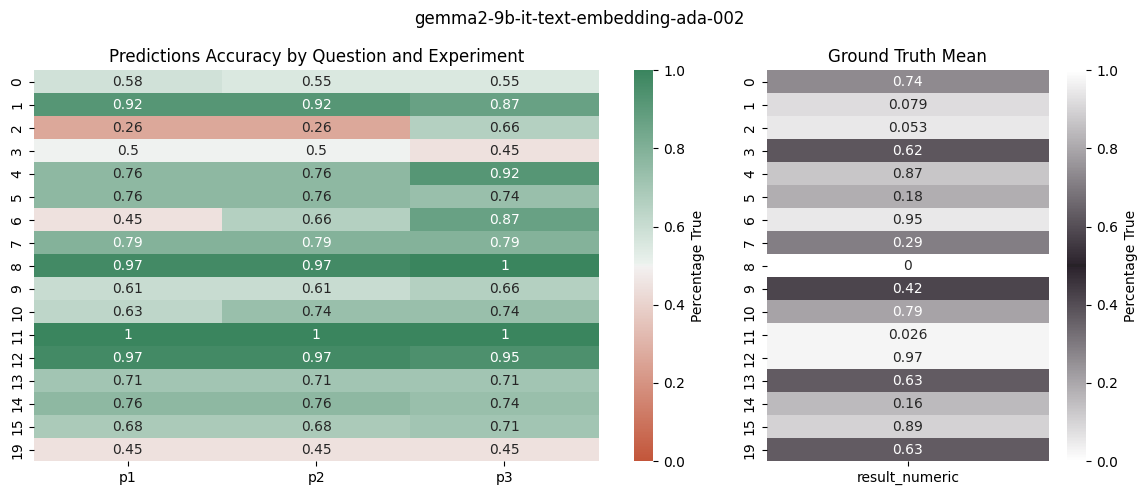

In [91]:
df1 = pd.read_csv(path + filename + '-p1.csv')
df1['experiment'] = 'p1'
df2 = pd.read_csv(path + filename + '-p2.csv')
df2['experiment'] = 'p2'
df3 = pd.read_csv(path + filename + '-p3.csv')
df3['experiment'] = 'p3'

# Combine the data
df = pd.concat([df1, df2, df3])

# Replace categorical 'YES'/'NO' with numeric 1/0
df.replace(('YES', 'NO'), (1, 0), inplace=True)

# Load human labels
df_labels = pd.read_csv('./data_out/human_labels.csv', delimiter=';')

# Create an empty DataFrame to store accuracy results
df_accuracy = pd.DataFrame(columns=['paper_id', 'experiment'] + [str(i) for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,19]])  # Assuming 20 questions

# Loop over each paper and experiment to calculate accuracy
for exp in ['p1', 'p2', 'p3']:
    # Filter predictions for the current experiment
    pred_exp = df[df['experiment'] == exp]

    # Initialize a list to store accuracy results for each paper in this experiment
    experiment_results = []

    for paper_id in range(38):  # Assuming paper_id range from 0 to 37
        # Get predictions and true values for the current paper
        pred = pred_exp[pred_exp['Paper'] == paper_id]
        true = df_labels[df_labels['paper_id'] == paper_id]

        # Create a list to store accuracy for each question in this paper/experiment
        accuracy_row = {'paper_id': paper_id, 'experiment': exp}

        # Loop over each question column (assuming questions are named '1', '2', ..., '20')
        for question in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,19]:  # Assuming 20 questions
            # Get predictions and true values for this question
            pred_val = pred[str(question)].values[0]
            true_val = true[str(question)].values[0]
            
            # Compare prediction to true value and store the result (1 for correct, 0 for incorrect)
            accuracy_row[str(question)] = 1 if pred_val == true_val else 0

        # Append the accuracy row to the experiment_results list
        experiment_results.append(accuracy_row)

    # Convert the experiment_results list into a DataFrame and append it to df_accuracy
    df_accuracy = pd.concat([df_accuracy, pd.DataFrame(experiment_results)], ignore_index=True)

# Plotting section
fig = plt.figure(figsize=(11.69,5))

gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Reshaping data for plotting (melt to long format)
df_test = df_accuracy.melt(id_vars=['paper_id', 'experiment'], value_vars=[str(i) for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,19]], 
                            var_name='question', value_name='result')

# Convert the 'question' column to integer for proper sorting
df_test['question'] = df_test['question'].astype(int)

# Convert result to numeric (for heatmap visualization)
df_test['result_numeric'] = df_test['result'].astype(int)

# Calculate the percentage of correct answers by question and experiment
percent_true_by_question_exp = df_test.groupby(['question', 'experiment'])['result_numeric'].mean().reset_index()

# Plot accuracy heatmap for predictions by experiment and question
g = sns.heatmap(
    percent_true_by_question_exp.pivot(index='question', columns='experiment', values='result_numeric'),
    annot=True, 
    cmap=sns.diverging_palette(20, 145, as_cmap=True), 
    cbar_kws={'label': 'Percentage True'},
    vmin=0, vmax=1, ax=ax1
)

# Ensure the y-axis is sorted numerically by 'question'
ax1.set_title('Predictions Accuracy by Question and Experiment')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_yticks(ax1.get_yticks())  # Get current y-ticks
if GROLTS_LABELS:
    ax1.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '15'])  # Sort y-ticks numerically

# Prepare the true labels data for comparison (per experiment and question)
df_lab = df_labels.melt(id_vars=['paper_id'], value_vars=[str(i) for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,19]], 
                        var_name='question', value_name='result')
df_lab['result_numeric'] = df_lab['result']
df_lab['question'] = df_lab['question'].astype(int)

# Calculate the percentage of correct answers by question in the true labels
percent_true_by_question_lab = df_lab.groupby('question')['result_numeric'].mean().reset_index()

# Plot heatmap for ground truth (mean values across all papers)
g = sns.heatmap(
    percent_true_by_question_lab.set_index('question'),
    annot=True,
    cmap=sns.diverging_palette(0, 0, l=100, center="dark", as_cmap=True),
    cbar_kws={'label': 'Percentage True'},
    vmin=0, vmax=1, ax=ax2
)
ax2.set_title('Ground Truth Mean')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks(ax2.get_yticks())  # Get current y-ticks
if GROLTS_LABELS:
    ax2.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '15'])

# Final title and layout adjustment
fig.suptitle(filename)
fig.tight_layout()
plt.show()
